In [1]:
import pandas as pd
import numpy as np
import os

# Notebook Intent
This notebook intends to provide a walk through the intended pipeline. This includes:
- Downloading the large files
- Training the models
- Evaluating the models

## 1. Download Large Files
This is the necessary first step, without which the repo can't work. As mentioned in the README, this can be achieved by just running
```bash
python download_large_files.py
```
Below we just replicate the main function

In [81]:
from download_large_files import *

destination="data_samples/generated"
if not os.path.isdir(destination):
    print(f"Creating Directory: {destination}")
    os.makedirs(destination)

for name, url in LARGE_FILES.items():
    print(f'Downloading: {name}')
    file_id = extract_google_drive_file_id(url)

    new_url = f"https://drive.google.com/uc?id={file_id}"
    gdown.download(new_url, f"{destination}/{name}", quiet=False)

Downloading: full_data_armenia_pre_correction_complex_only.csv


Downloading...
From (original): https://drive.google.com/uc?id=1JJrjrWbs-7X9xGTrwiBcp-om2dK-GnFR
From (redirected): https://drive.google.com/uc?id=1JJrjrWbs-7X9xGTrwiBcp-om2dK-GnFR&confirm=t&uuid=4f28e4a6-2de9-40ee-9fbe-bcc02253bb82
To: /Users/lucamingardi/Desktop/supervised/complex_audits_frauds/data_samples/generated/full_data_armenia_pre_correction_complex_only.csv
100%|██████████| 446M/446M [00:15<00:00, 29.0MB/s] 


Downloading: full_data_armenia_pre_correction.csv


Downloading...
From (original): https://drive.google.com/uc?id=1JKavQC7uTO1GRoP4nPlvWFl6tdoNHLqe
From (redirected): https://drive.google.com/uc?id=1JKavQC7uTO1GRoP4nPlvWFl6tdoNHLqe&confirm=t&uuid=7a79a9fd-a6d2-459e-abfc-707a4a9e5875
To: /Users/lucamingardi/Desktop/supervised/complex_audits_frauds/data_samples/generated/full_data_armenia_pre_correction.csv
100%|██████████| 446M/446M [00:21<00:00, 20.9MB/s] 


Downloading: tin_tax_year_results.pkl


Downloading...
From (original): https://drive.google.com/uc?id=1JL5eMFhyNI_fCMQZqB50ekv822_duVT8
From (redirected): https://drive.google.com/uc?id=1JL5eMFhyNI_fCMQZqB50ekv822_duVT8&confirm=t&uuid=f0618193-141b-42cc-b02c-dd622bc0fed9
To: /Users/lucamingardi/Desktop/supervised/complex_audits_frauds/data_samples/generated/tin_tax_year_results.pkl
100%|██████████| 154M/154M [00:07<00:00, 19.7MB/s] 


## 2. Create Data
If data in 1. is not relevant anymore, a new dataset needs to be created. This can be achieved by modifying `merging_config` in the `config.py` file. 
Then, we can just run
```bash
python merge_data.py
```

## 3. Train Models
For this step we need to modify `training_config` in the `config.py` file. Then, we can just run
```bash
python training_pipeline.py
```
Below we just replicate the main function

In [2]:
from config import df_path
from training_pipeline import *

training_config = {
    "df_path": df_path, # path to the saved data
    "target": "FRAUD_OR_CORRECT", # select target for training
    "training_years": [2022], # select which years to keep in data for training
    "save_path": None, # set to None to avoid overwriting the saved models
    "interpretable": False, # set to False because InterpretableAI license is needed to run training
}

train_X, train_y, model_names, models = training_production(training_config)

/Users/lucamingardi/Desktop/supervised/complex_audits_frauds/training_pipeline.py:669: DtypeWarning: Columns (277) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(df_path)


## 4. Evaluate Models
For this step we need to modify `evaluation_config` in the `config.py` file. Then, we can just run
```bash
python evaluation_pipeline.py
```
Below we just replicate the main function

/home/odyssey/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/odyssey/Documents/Daniam/Mindwise/newdataprep/supervised/complex_audits_frauds/evaluation_pipeline.py:472: DtypeWarning: Columns (276,277,279,281,283) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(df_path)
/home/odyssey/.local/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:39:54] WARNING: /workspace/src/collective/../data/../common/error_msg.h:80: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_mode

Computing SHAP values at TIN-TAX YEAR level


Tree Samples Explanation: 100%|██████████████████████████████████████████████████████████████████████| 74400/74400 [00:00<00:00, 537763.72sample/s]


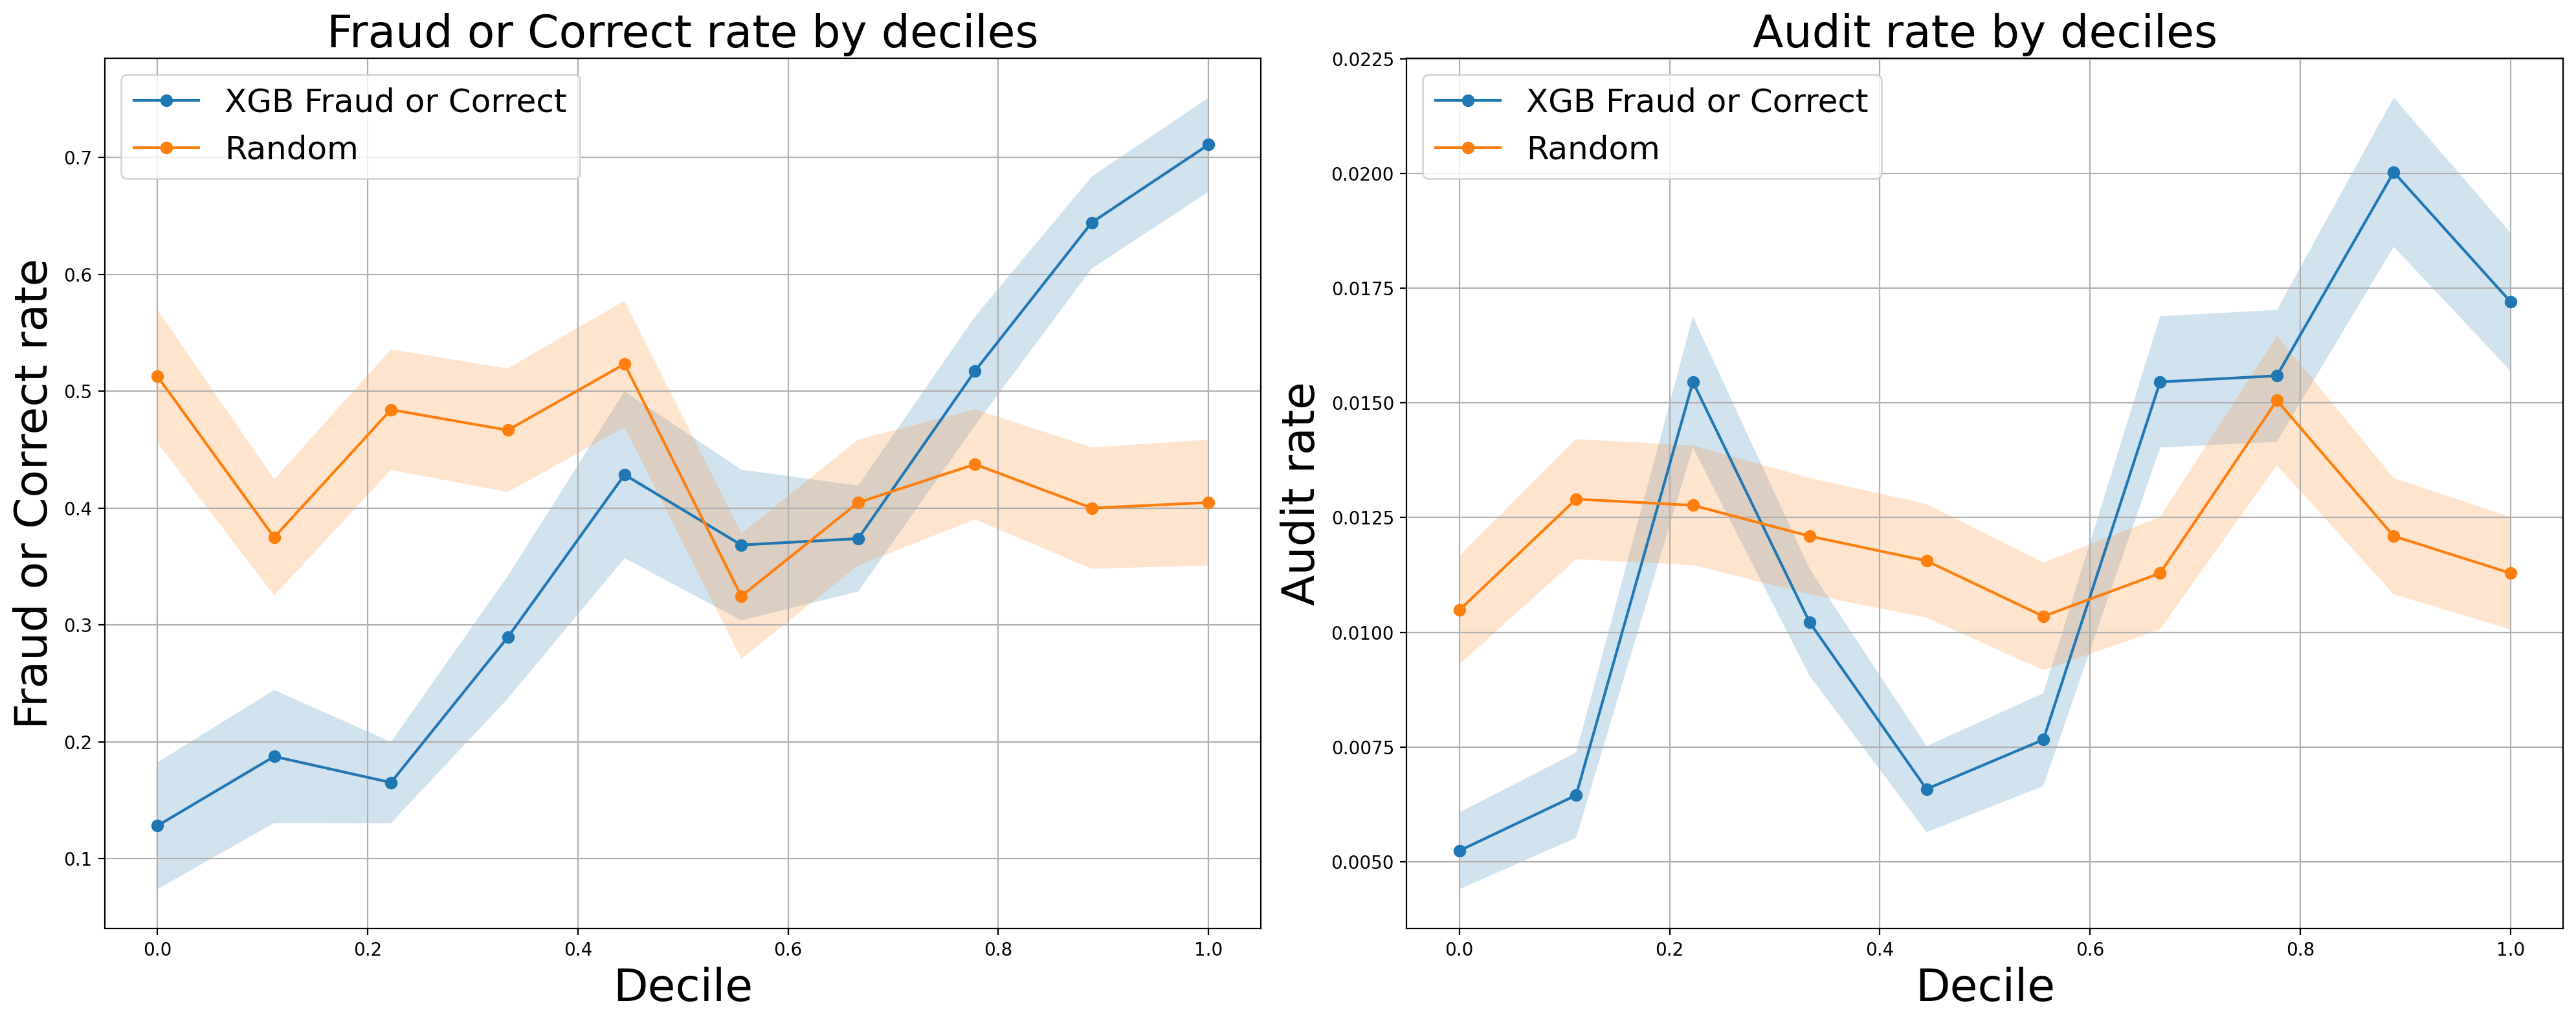

Predict: FRAUD_OR_CORRECT
Accuracy XGB/RF: 0.6603/0.6200
AUC XGB/RF: 0.7306/0.7425


In [2]:
from config import df_path
from evaluation_pipeline import *

evaluation_config = {
    "df_path": df_path, # path to the saved data
    "models_path": "models", # path to the trained models
    "inference": False, # if False, compute metrics
    "target": "FRAUD_OR_CORRECT", # select target for evaluation
    "training_years": [2022], # load the model trained on these years
    "evaluate_years": [2023], # use these years for evaluation (inference=False)
    "figures_path": None, # path where to save rates figure (inference=False) - Set to None to avoid overwriting current one
    "train_regression": False, # if True, retrain the regression model for ranking (currently saved in `models/size_prediction/size_models.pkl`)
    "ranking": "predicted_change_class", # criteria for ranking
    "compute_tin_level": True, # if True, compute TIN level interpretation and save at `data_samples/generated/tin_tax_year_results.pkl` (False because already saved)
    "interpretable": False, # if True, save the TIN level interpretation also for InterpretableAI trees (False because already saved)
    "best_model": 'xgb', # the model used to rank the predicted probabilities (either xgb or rf)
}

ranked_preds, dict_tin_tax_year, full_features = evaluation_production(evaluation_config)

## 5. Model Interpretation

### Global Interpretation of the XGB Model
This is evaluated on the training set, because it must be evaluated on the audited population to understand the signal that the model learned

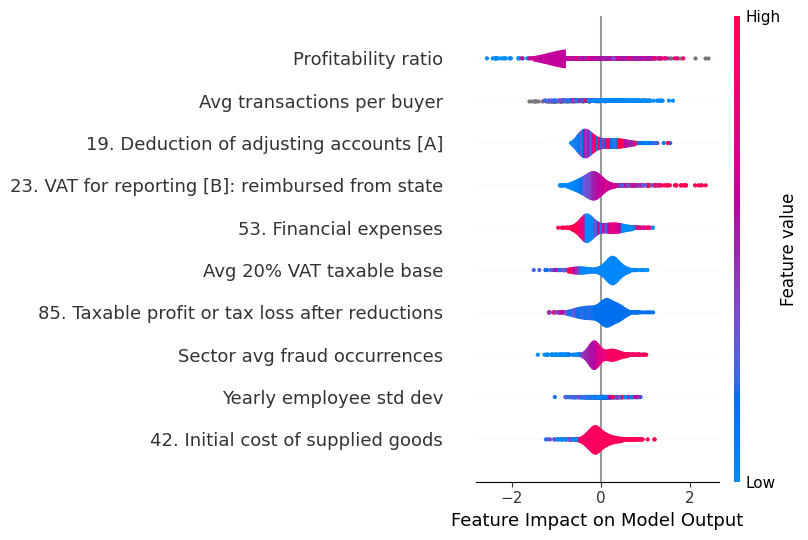

In [6]:
with open('models/FRAUD_OR_CORRECT/training_years_[2022]/data_all/global_shap_values.pkl', 'rb') as f:
    dict_values = pickle.load(f)
shap_values = dict_values['shap_values']
model_features = dict_values['model_features']

top_features = plot_shap_summary(
    train_X[model_features], shap_values, map_features=True, n_features=10, save_path=None
)

### Global Interpretation of the InterpretableAI Model
**Note**: It takes about ~4 minutes to load the iai package

In [8]:
from interpretableai import iai
from feature_map import mapping_short

# Load Optimal Tree
lnr_oct = iai.read_json('models/FRAUD_OR_CORRECT/training_years_[2022]/data_all/lnr_oct.json')

# Get Features used by the model
features_used = lnr_oct.get_features_used()

# Select only the features that are actually used by the model
new_feature_map = {key: val for (key, val) in mapping_short.items() if key in features_used}

# Visualize in Browser with mapped features
mapped_lnr_oct = iai.TreePlot(lnr_oct, feature_renames=new_feature_map)

mapped_lnr_oct.show_in_browser() # display in browser
mapped_lnr_oct # display below

/Users/lucamingardi/miniconda3/envs/armenia/lib/python3.11/site-packages/interpretableai/iaitrees.py:1134: FutureWarning: 'iai.TreePlot(lnr)' is deprecated, use `lnr.TreePlot(...)`
  _warnings.warn(


IAIBase.Visualization{IAITrees.TreeVisualization}(Fitted OptimalTreeClassifier:
  1) Split: A87 < 0.2329
    2) Split: var2 < 0.7666
      3) Split: v16a < 97711222.5
        4) Split: month_8 < 2.5
          5) Predict: false (P(true) = 35.09%), [37,20], 57 points, error 0.4555
          6) Predict: false (P(true) = 3.54%), [109,4], 113 points, error 0.06829
        7) Split: buyer_COUNT_mean < 24.17
          8) Predict: true (P(true) = 61.76%), [13,21], 34 points, error 0.4723
          9) Predict: false (P(true) = 14.46%), [71,12], 83 points, error 0.2474
      10) Predict: true (P(true) = 68.75%), [5,11], 16 points, error 0.4297
    11) Split: A87 < 82.12
      12) Split: v16b_mean < 8870910.7
        13) Split: A85 < 12.12
          14) Predict: true (P(true) = 67.57%), [12,25], 37 points, error 0.4383
          15) Predict: false (P(true) = 29.07%), [61,25], 86 points, error 0.4124
        16) Split: v7a_mean < 67132967.5
          17) Predict: true (P(true) = 85.11%), [7,40], 47 points, error 0.2535
          18) Predict: false (P(true) = 26.83%), [30,11], 41 points, error 0.3926
      19) Split: v23b < 8405181
        20) Split: level1_var3 < 0.003283
          21) Predict: true (P(true) = 70.00%), [3,7], 10 points, error 0.42
          22) Predict: false (P(true) = 18.45%), [137,31], 168 points, error 0.3009
        23) Split: A53 < -17.21
          24) Predict: true (P(true) = 54.88%), [37,45], 82 points, error 0.4952
          25) Predict: false (P(true) = 30.00%), [56,24], 80 points, error 0.42, Dict{Symbol, Any}(:feature_renames => Dict("A85" => "85. Taxable profit or tax loss after reductions", "A53" => "53. Financial expenses", "v23b" => "23. VAT for reporting [B]: reimbursed from state", "var2" => "Prop 16.67% VAT base in total VAT sales", "v16a" => "16. Total VAT credit [A]. Taxation base", "A87" => "87. Taxable profit after applying tax benefits", "v7a_mean" => "Avg 20% VAT taxable base", "month_8" => "Employees in August", "v16b_mean" => "Avg total VAT credit", "level1_var3" => "Sector avg prop 0% VAT", "buyer_COUNT_mean" => "Avg transactions per buyer")))

### TIN-level Interpretation of the XGB Model

In [9]:
with open('data_samples/generated/tin_tax_year_results.pkl', 'rb') as f:
    dict_tin_tax_year = pickle.load(f)

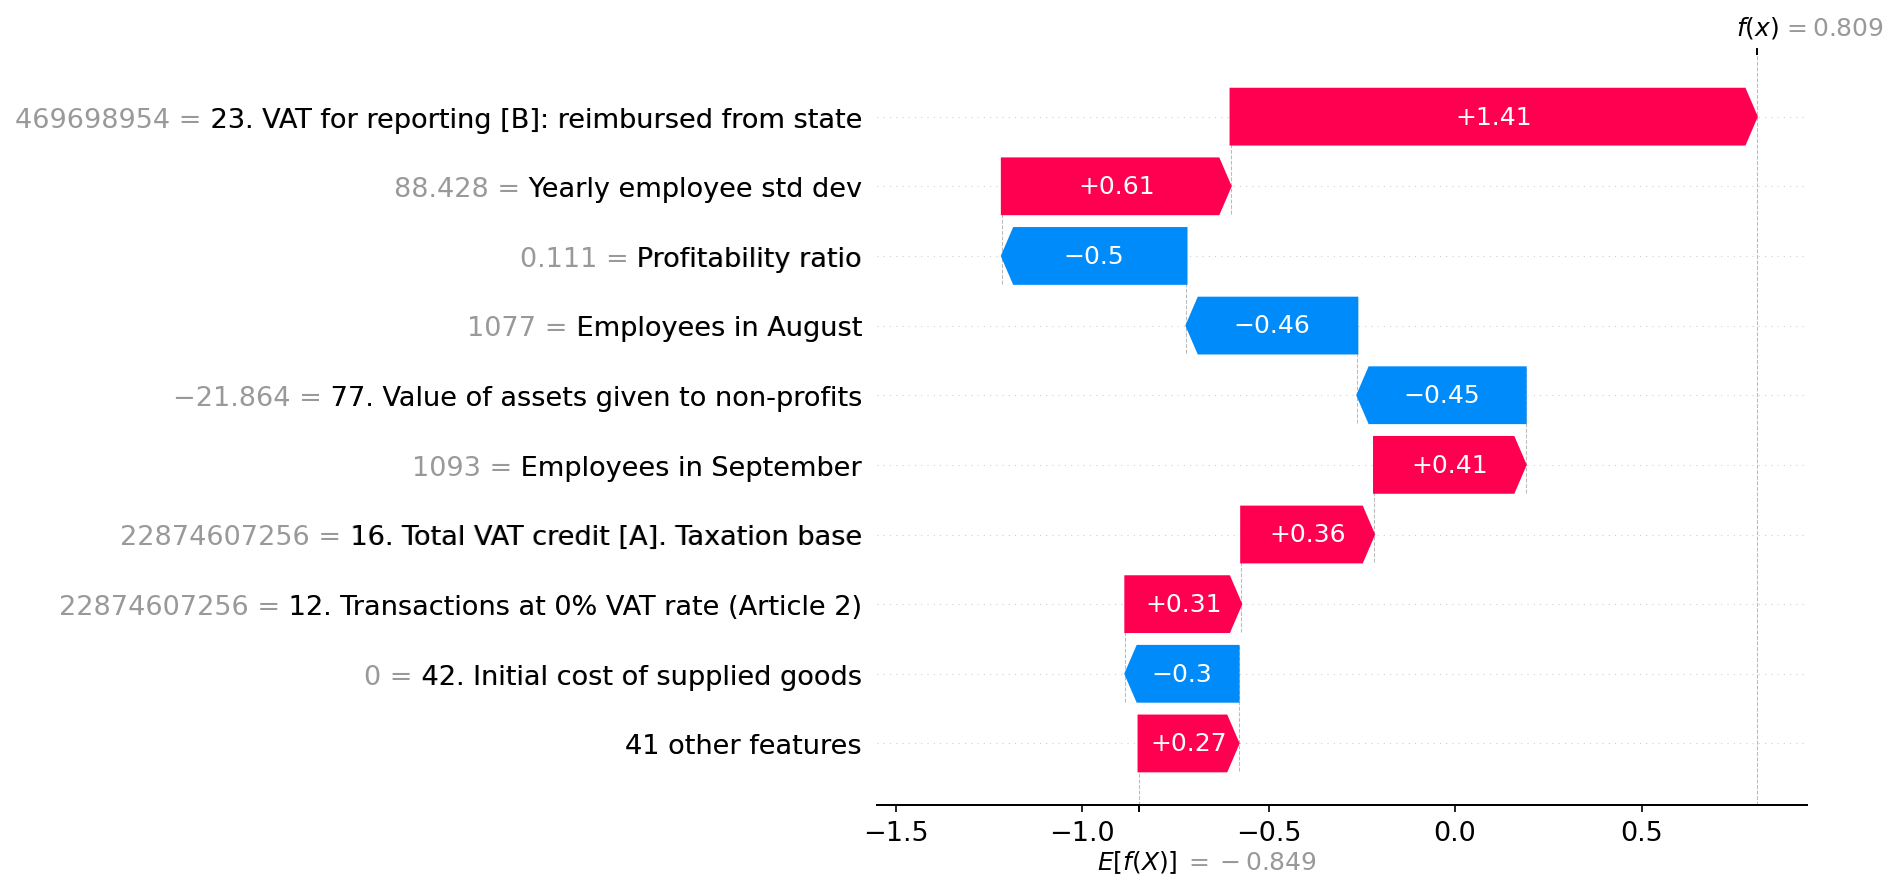

In [10]:
from shap_functions import plot_shapley_per_sample
TIN = 927464691
TAX_YEAR = 2023
n_features = 10

sample = dict_tin_tax_year[TIN][TAX_YEAR]['sample']
sample_shap_values = dict_tin_tax_year[TIN][TAX_YEAR]['sample_shap_values']
expected_value = dict_tin_tax_year[TIN][TAX_YEAR]['expected_value']
top_features_sample = plot_shapley_per_sample(
    sample_shap_values, expected_value, sample, map_features=True, feature_names=sample.index, n_features=n_features, save_path=None
)

### TIN-level Interpretation of the OCT Model

In [13]:
print(dict_tin_tax_year[TIN][TAX_YEAR]['sample_tree_explanation'])

Rules used to predict sample 1:
  1) Split: 87. Taxable profit after applying tax benefits (=2555.5) ≥ 0.2329
    11) Split: 87. Taxable profit after applying tax benefits (=2555.5) ≥ 82.12
      19) Split: 23. VAT for reporting [B]: reimbursed from state (=469698954) ≥ 8405181
        23) Split: 53. Financial expenses (=0) ≥ -17.21
          25) Predict: false (P(true) = 30.00%)

